<a href="https://colab.research.google.com/github/mantoan-thi/Machine-Learning-Projects-with-Python/blob/main/Previs%C3%A3o_de_defeitos_QA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importando bibliotecas essenciais

In [ ]:
#!pip install --upgrade pandas
#!pip install --upgrade pandas-datareader

In [ ]:
!pip install openpyxl
!pip install pandas --upgrade

In [ ]:
!pip install s3fs --upgrade

In [2]:
# Modelagem
import pandas as pd
from pandas_datareader import data as web
import plotly.graph_objects as go
from datetime import date, datetime
import numpy as np
from matplotlib import pyplot
import plotly.express as px

# Redes neurais
from keras.models import Sequential
from keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
from keras.models import load_model

# Facebook
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from fbprophet.plot import plot_plotly, plot_components_plotly

# ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.animation import FuncAnimation
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib notebook
sns.set_context("paper")
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Dados da Bolsa

In [58]:
# criar um DataFrame vazio
df = pd.DataFrame()

# escolher a ação desejada
acao = 'ITUB3.SA'
 
# importar dados para o DataFrame
df = web.DataReader(acao, data_source='yahoo', start='01-01-2019')

trace1 = {
    'x': df.index,
    'open': df.Open,
    'close': df.Close,
    'high': df.High,
    'low': df.Low,
    'type': 'candlestick',
    'name': acao,
    'showlegend': False
}
 
data = [trace1]
layout = go.Layout()
 
fig = go.Figure(data=data, layout=layout)
fig.show()

In [59]:
def retorna_ativos(acao):
  # escolher a ação desejada
  #acao = 'ITUB3.SA'

  # importar dados para o DataFrame
  df = web.DataReader(acao, data_source='yahoo', start='01-01-2020')['Adj Close']
  df = pd.DataFrame(df).reset_index()
  df.rename(columns={'Date': 'ds','Adj Close':'y'},inplace=True)
  data = df[['ds','y']]
  data.reset_index(drop=True, inplace=True)
  return data

#Modelagem de dados

In [29]:
# Carrega a planilha
df = pd.read_excel('/content/Indicadores Internos SAP rev 17A.xlsx',sheet_name='Base de dados')

# Renomear as colunas
df.columns = df.iloc[1]

# Excluir as linhas 0 e 1
for i in range(0,2):
  df.drop(i,inplace=True)

# Retira o index
df.reset_index(drop=True, inplace=True)

# Exclui as linhas que contém: fechamento e 200%
df = df[(df['Processo']!='fechamento') & (df['Processo']!='200%')]

# Retirando as colunas abaixo
df = df[['Data','Turno','Projeto','QTD DEF']]

# Excluir os valores nan
df.dropna(inplace=True)

# Converte as datas
df['Data'] = df['Data'].apply(lambda x: x.strftime('%d/%m/%Y'))

In [4]:
lista_de = ['T9','T9LT novo','TRYX NOVO','360b','833B','TRYX novo','T5NR novo','T9LM NOVO','T5R NOVO','T5RN NOVO','T5NM NOVO','T5NM']
lista_para = ['T9LT','T9LT','TRYX','360B','833W','TRYX','T5NR','T9LT','T5NR','T5NR','T5NR','T5NR']

# Ajustando...
de = 'T9'
para = 'T9LT'
for i in range(0,len(lista_de)):
  df['Projeto'] = df['Projeto'].apply(lambda x: lista_para[i] if x == lista_de[i] else x)

# Extraindo os projetos
lista_proj = list(set(df['Projeto']))

print('Quantidade de projetos: ',len(lista_proj))
lista_proj

Quantidade de projetos:  15


['833W',
 'T9LM',
 '474B',
 'Kongsberg',
 'TRYX',
 'kanjiko',
 'T5NR',
 'Actros',
 '360B',
 '740B',
 'T9LT',
 'VIVA PUP',
 'Mahle',
 'T5/TR',
 'T00A']

In [5]:
# Gráfico...
n_df = df[df['Projeto']=='360B']
fig = px.line(n_df, x='Data', y='QTD DEF', title='Projetos',color='Projeto')
fig.show()

Plotar gráficos

In [6]:
turnos = ['A','B']
resumo = []

for t in turnos:
  for proj in lista_proj:
    new_df = df[(df['Turno']==t) & (df['Projeto']==proj)]
    resumo.append([proj,t,new_df.shape[0]])

resumo = pd.DataFrame(resumo,columns=['Projeto','Turno','Qtde def'])
resumo.sort_values(by=['Qtde def'], ascending=False,inplace=True)

# Top 10...
resumo.head(10)

,Projeto,Turno,Qtde def
8,360B,A,10491
9,740B,A,9303
23,360B,B,7403
24,740B,B,6566
2,474B,A,2729
13,T5/TR,A,2267
14,T00A,A,2141
10,T9LT,A,1640
4,TRYX,A,1320
17,474B,B,1144


Funções

In [7]:
def previsao(df,p,proj):
  #df['cap'] = 8.5
  #m = Prophet(growth='logistic')
  m = Prophet(daily_seasonality = True)
  m.fit(df)
  future = m.make_future_dataframe(periods=p)
  #future['cap'] = 8.5
  forecast = m.predict(future)
  #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  print('Projeto: ',proj)
  y_pred = forecast['yhat'][-(p):].values
  print('média de defeitos previsto para os próximos 30 dias: ',y_pred.mean())
  fig1 = m.plot(forecast,figsize=(12,8))
  a = add_changepoints_to_plot(fig1.gca(), m, forecast)

In [8]:
def previsao_comp(df,p,proj):
  m = Prophet()
  m = Prophet(changepoint_prior_scale=0.001)
  m.fit(df)
  future = m.make_future_dataframe(periods=p)
  forecast = m.predict(future)
  #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  print('Projeto: ',proj)
  fig2 = m.plot_components(forecast)

In [9]:
def previsao_comp_x(df,p,proj):
  m = Prophet()
  m.fit(df)
  future = m.make_future_dataframe(periods=p)
  forecast = m.predict(future)
  y_true = df['y'][-(p):].values
  y_pred = forecast['yhat'][-(p):].values
  mae = mean_absolute_error(y_true, y_pred)
  print('Projeto: ',proj)
  print('MAE: %.3f' % mae)
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  pyplot.figure(figsize=(15,8))
  pyplot.plot(y_true, label='Actual')
  pyplot.plot(y_pred, label='Predicted')
  pyplot.legend()
  pyplot.show()

In [10]:
pd.DataFrame(lista_proj)

,0
0,833W
1,T9LM
2,474B
3,Kongsberg
4,TRYX
5,kanjiko
6,T5NR
7,Actros
8,360B
9,740B


In [36]:
t='A'
p = '360B'
tempo = 60
new_df = df[df['Projeto']== p]
new_df = new_df.groupby(by=['Data'])['QTD DEF', 'Turno', 'Projeto'].sum()
new_df = pd.DataFrame(new_df)
new_df.reset_index(inplace=True,drop=False)
new_df.rename(columns={'Data': 'ds','QTD DEF': 'y'}, inplace = True)
new_df.dropna(inplace=True)
print('Projeto: ',p)

Projeto:  360B


In [34]:
df.columns

Index(['Data', 'Turno', 'Projeto', 'QTD DEF'], dtype='object', name=1)

In [51]:
def carregar(prjt, trn,tmp):
  # Carrega a planilha
  df = pd.read_excel('/content/Indicadores Internos SAP rev 17A.xlsx',sheet_name='Base de dados')

  # Renomear as colunas
  df.columns = df.iloc[1]

  # Excluir as linhas 0 e 1
  for i in range(0,2):
    df.drop(i,inplace=True)

  # Retira o index
  df.reset_index(drop=True, inplace=True)

  # Exclui as linhas que contém: fechamento e 200%
  df = df[(df['Processo']!='fechamento') & (df['Processo']!='200%')]

  # Retirando as colunas abaixo
  df = df[['Data','Turno','Projeto','QTD DEF']]

  # Excluir os valores nan
  df.dropna(inplace=True)

  # Converte as datas
  df['Data'] = df['Data'].apply(lambda x: x.strftime('%d/%m/%Y'))

  lista_de = ['T9','T9LT novo','TRYX NOVO','360b','833B','TRYX novo','T5NR novo','T9LM NOVO','T5R NOVO','T5RN NOVO','T5NM NOVO','T5NM']
  lista_para = ['T9LT','T9LT','TRYX','360B','833W','TRYX','T5NR','T9LT','T5NR','T5NR','T5NR','T5NR']

  # Ajustando...
  de = 'T9'
  para = 'T9LT'
  for i in range(0,len(lista_de)):
    df['Projeto'] = df['Projeto'].apply(lambda x: lista_para[i] if x == lista_de[i] else x)

  t=trn
  p = prjt
  tempo = tmp
  new_df = df[(df['Turno']==t) & (df['Projeto']==p)]
  #new_df = df[df['Projeto']==p]
  new_df = new_df.groupby(by=['Data'])['QTD DEF'].sum()
  new_df = pd.DataFrame(new_df)
  new_df.reset_index(inplace=True,drop=False)
  new_df.rename(columns={'Data': 'ds','QTD DEF': 'y'}, inplace = True)
  new_df.dropna(inplace=True)
  print('Projeto: ',p)

  return new_df

#Previsão de defeitos com Prophet do Facebook

In [28]:
# Carregando dados
t='A'
p = '360B'
tempo = 60

# Prever defeitos
new_df = carregar('360B','A',30)

# Prever preços
#new_df = retorna_ativos('ITUB3.SA')

Projeto:  360B


In [29]:
# The Prophet class (model)
fbp = Prophet(daily_seasonality = True) 
 # Fit the model 
fbp.fit(new_df)
# We need to specify the number of days in future
# We'll be predicting the full 2021 stock prices
fut = fbp.make_future_dataframe(periods=tempo) 
forecast = fbp.predict(fut)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [30]:
# Plot dados
lista_prev = []
y_pred = forecast['yhat'][-tempo:].values
print('Média de defeitos previsto para os próximos '+str(tempo)+' dias: ',round(y_pred.mean(),2))
previsao_def = pd.DataFrame(forecast[['ds','yhat']][-tempo:].values,columns=['Data','Qtde defeitos'])
previsao_def.head()

Média de defeitos previsto para os próximos 60 dias:  41.24


,Data,Qtde defeitos
0,2021-12-12,36.936963
1,2021-12-13,40.98687
2,2021-12-14,42.426941
3,2021-12-15,39.262624
4,2021-12-16,38.381911


In [31]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(fbp, forecast)

Tendência, componentes semanais, sazonais, anuais e diários

Projeto:  360B


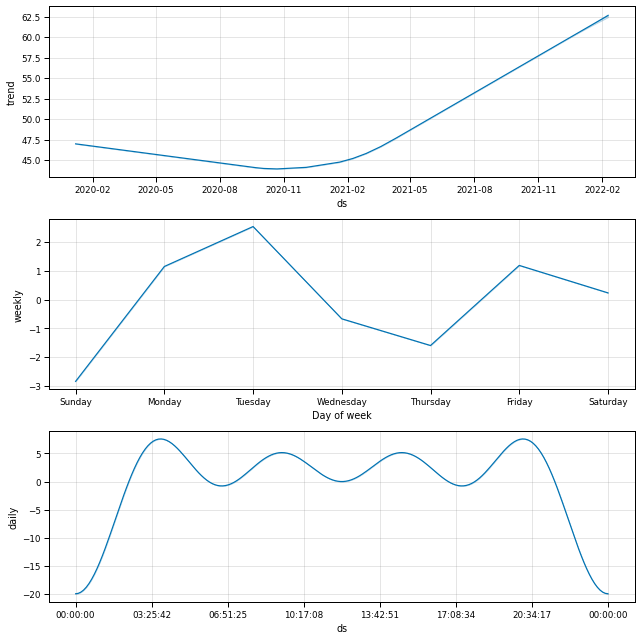

In [32]:
print('Projeto: ',p)
fbp.plot_components(forecast)
plt.show()

# Previsão de defeitos com rede LSTM - Tem que ter pelo menos 300 coletas de dados

In [33]:
# Carregando dados
t='A'
p = '360B'
tempo = 60

# Prever defeitos
df = carregar('360B','A',30)

# Prever preços
#df = retorna_ativos('ITUB3.SA')

Projeto:  360B


O objetivo é prever o que acontecerá com o valor de fechamento de uma ação em n dias (forward_days), tendo como base os m dias anteriores (look_back).

In [34]:
look_back = 40
forward_days = 10
num_periods = 30

Data visualization ( Vizualizando os dados )

In [35]:
fig = px.line(df, x='ds', y='y', title=p)
fig.show()

Data normalization ( Normalizando os dados )

In [36]:
array = df['y'].values.reshape(df.shape[0],1)
array[:5]

array([[1],
       [32],
       [31],
       [52],
       [35]], dtype=object)

In [37]:
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
array = scl.fit_transform(array)
array[:5]

array([[0.        ],
       [0.28703704],
       [0.27777778],
       [0.47222222],
       [0.31481481]])

Dividir os dados em Treino/Validação para o modelo LSTM e os dados de Teste - 
Vamos separar para os últimos k períodos (num_periods) para testar o modelo. A cada período, o modelo irá prever os próximos n dias. O resto será utilizado para o treinamento (Treino e Validação).

In [38]:
#split in Train and Test

division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [39]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [40]:
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)

Treinando a LSTM

In [98]:
#Optionaly, you can load a model
#model = load_model('model.h5')

In [58]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 50

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=len(X_train), verbose=1)

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 3.3942 - accuracy: 0.1600 - val_loss: 3.1625 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 46ms/step - loss: 3.2622 - accuracy: 0.1600 - val_loss: 2.7762 - val_accuracy: 0.2857
Epoch 3/50
1/1 [==============================] - 0s 44ms/step - loss: 2.9010 - accuracy: 0.1200 - val_loss: 2.2121 - val_accuracy: 0.2857
Epoch 4/50
1/1 [==============================] - 0s 49ms/step - loss: 2.3086 - accuracy: 0.1200 - val_loss: 2.1232 - val_accuracy: 0.2857
Epoch 5/50
1/1 [==============================] - 0s 43ms/step - loss: 2.1883 - accuracy: 0.1200 - val_loss: 1.8425 - val_accuracy: 0.2857
Epoch 6/50
1/1 [==============================] - 0s 46ms/step - loss: 1.9479 - accuracy: 0.1200 - val_loss: 1.6057 - val_accuracy: 0.2857
Epoch 7/50
1/1 [==============================] - 0s 57ms/step - loss: 1.7776 - accuracy: 0.1200 - val_loss: 1.3923 - val_accuracy: 0.2857
Epoch 8/50
1/1 [=========

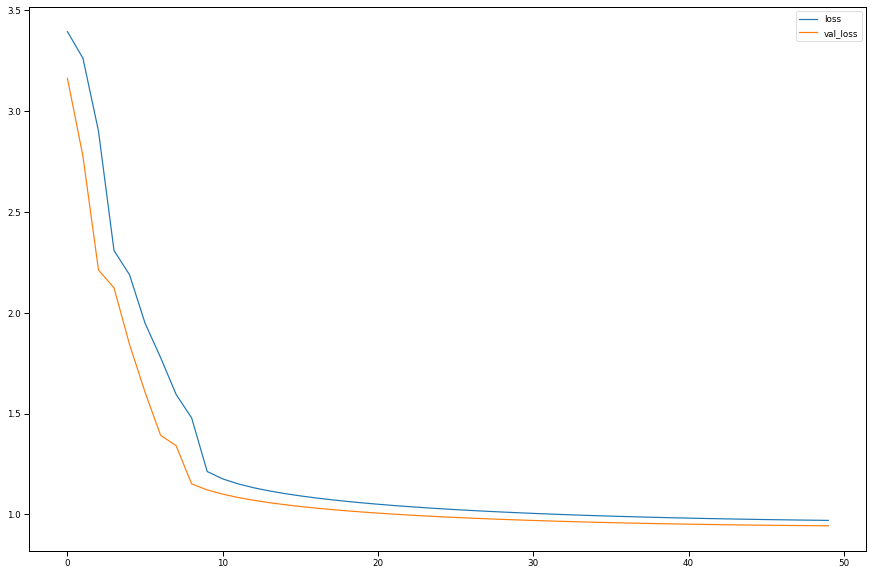

In [59]:
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

In [60]:
#Saving the model
file_name = 'Redes/single-company/LSTM_compA_LB{}_FD{}_E{}_F{}_S{}.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
model.save(file_name)
print("Saved model `{}` to disk".format(file_name))

Saved model `Redes/single-company/LSTM_compA_LB40_FD10_E50_F50_S30.h5` to disk


Vamos prever os dados de Teste para o resultado

In [61]:
Xt = model.predict(X_test)

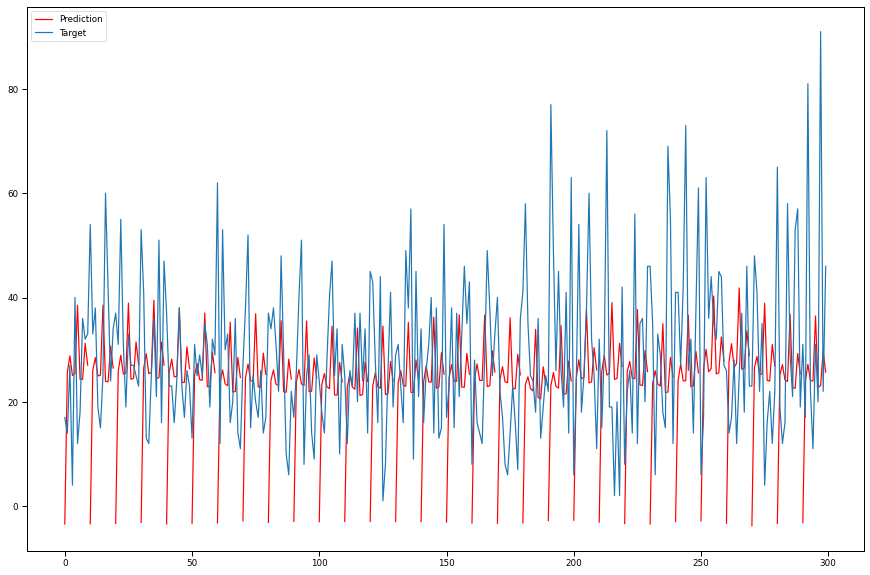

In [62]:
plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, scl.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()

Prever todos os dados para ver como o modelo reage aos dados de Treino e Teste

In [63]:
division = len(array) - num_periods*forward_days

leftover = division%forward_days+1

array_test = array[division-look_back:]
array_train = array[leftover:division]

In [64]:
Xtrain,ytrain = processData(array_train,look_back,forward_days,forward_days)
Xtest,ytest = processData(array_test,look_back,forward_days,forward_days)

In [65]:
Xtrain = model.predict(Xtrain)
Xtrain = Xtrain.ravel()

Xtest = model.predict(Xtest)
Xtest = Xtest.ravel()

In [66]:
y = np.concatenate((ytrain, ytest), axis=0)

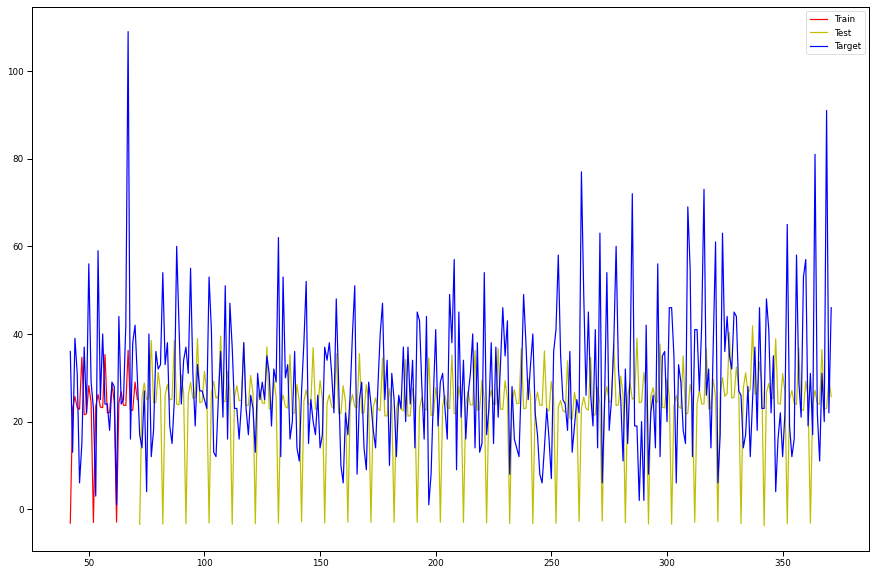

In [67]:
plt.figure(figsize = (15,10))

# Data in Train/Validation
plt.plot([x for x in range(look_back+leftover, len(Xtrain)+look_back+leftover)], scl.inverse_transform(Xtrain.reshape(-1,1)), color='r', label='Train')
# Data in Test
plt.plot([x for x in range(look_back +leftover+ len(Xtrain), len(Xtrain)+len(Xtest)+look_back+leftover)], scl.inverse_transform(Xtest.reshape(-1,1)), color='y', label='Test')

#Data used
plt.plot([x for x in range(look_back+leftover, look_back+leftover+len(Xtrain)+len(Xtest))], scl.inverse_transform(y.reshape(-1,1)), color='b', label='Target')

#Initial data. It should overlap the data used
#plt.plot(scl.inverse_transform(array), color='b', label='Esperado')

plt.legend(loc='best')
plt.show()

# Previsão de defeitos com ARIMA

In [171]:
# Carregando dados
t='A'
p = '740B'
tempo = 60

# Prever defeitos
#df = carregar(p,'A',30)

# Prever preços
df = retorna_ativos('ITUB3.SA')

df.sort_values(by=['ds'],inplace=True)
df.set_index('ds', inplace=True)

Criando base de treino e teste

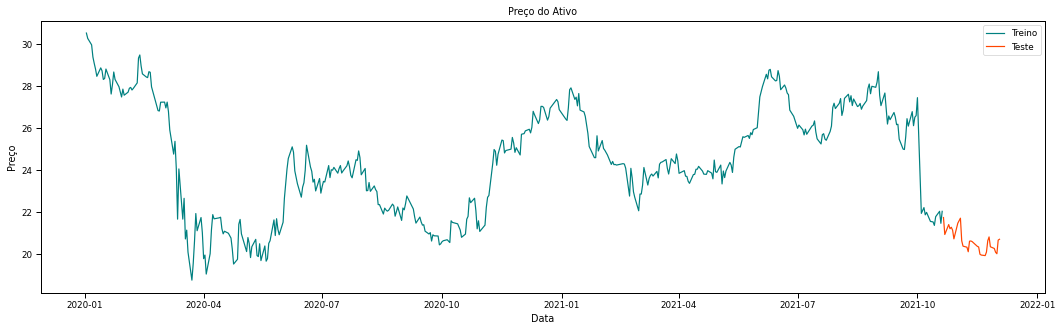

In [193]:
dias = 30
treino = df.iloc[:-dias,0:1].copy()
teste = df.iloc[-dias:,0:1].copy()
plt.figure(figsize=(18,5))
plt.title('Preço do Ativo')
plt.plot(treino['y'], color='teal')
plt.plot(teste['y'], color='orangered')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('Preço')
plt.show()

Teste de estacionariedade e verificando Correlações

Para se criar uma previsão de série temporal é necessário que ela seja estacionária, ou seja, que ela tenha as seguintes condições relativamente constantes: média, variância e autocorrelação.

Abaixo irei usar a função abaixo para plotar a série, sua distribuição, autocorrelação e autocorrelação parcial além de checar a estacionariedade usando o teste de Dickey Fuller:

In [194]:
#criando uma função para plotar o gráfico e mostrar o resultado do teste:
def checar_estacionariedade(y, lags_plots=48, figsize=(22,8)):
    "Use Series como parâmetro"
    
    # Criando plots do DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize, color='teal')
    ax1.set_title('Série de Preços')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2, color='teal');
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3, method='ols', color='teal');
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4, color='teal')
    ax4.set_title('Distribuição dos Preços')

    plt.tight_layout()
    
    print('Resultados do teste de Dickey-Fuller:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Teste Statistico','Valor-P','Lags Usados','Números de Observações'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Valores Críticos (%s)"%key] = value.round(4)
        
    print(adftest)

Para verificar se a série de treino é estacionária, iremos usar o valor P de 5% como base para estacionariedade, caso o valor P do teste seja inferior a 5% podemos considerar que a série é estacionária:

Resultados do teste de Dickey-Fuller:
Teste Statistico           -2.6508
Valor-P                     0.0829
Lags Usados                 1.0000
Números de Observações    445.0000
Valores Críticos (1%)      -3.4451
Valores Críticos (5%)      -2.8681
Valores Críticos (10%)     -2.5702
dtype: float64


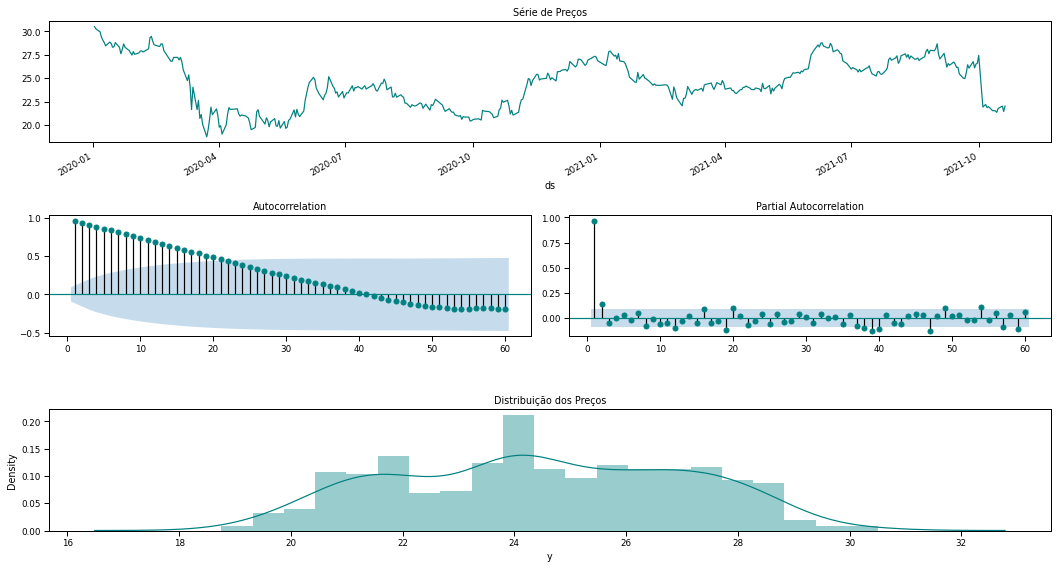

In [195]:
# Aqui os dados de qualidade estão no formato int, sendo necessário transforma para float
treino['y'] = treino['y'].apply(lambda x: float(x))


checar_estacionariedade(treino['y'], lags_plots=60)

Analisando o gráfico da série de preços, nota-se que ele tem uma leve tendência de alta, observando os dados estatísticos a série ficou com o valor P de 21,5%, a distribuição dos dados não segue uma normalidade gaussiana, e as características da autocorrelação mostram correlações significativas em todos os lags, isso é sinal de uma série com tendência e que pode-se fazer ao menos uma diferenciação.

Assim, essa série não satisfaz os critérios estabelecidos para ser considerada estacionária.

Vou fazer a primeira diferenciação para retirar a tendência e ficar somente as movimentações dia-a-dia:

Resultados do teste de Dickey-Fuller:
Teste Statistico          -24.5164
Valor-P                     0.0000
Lags Usados                 0.0000
Números de Observações    445.0000
Valores Críticos (1%)      -3.4451
Valores Críticos (5%)      -2.8681
Valores Críticos (10%)     -2.5702
dtype: float64


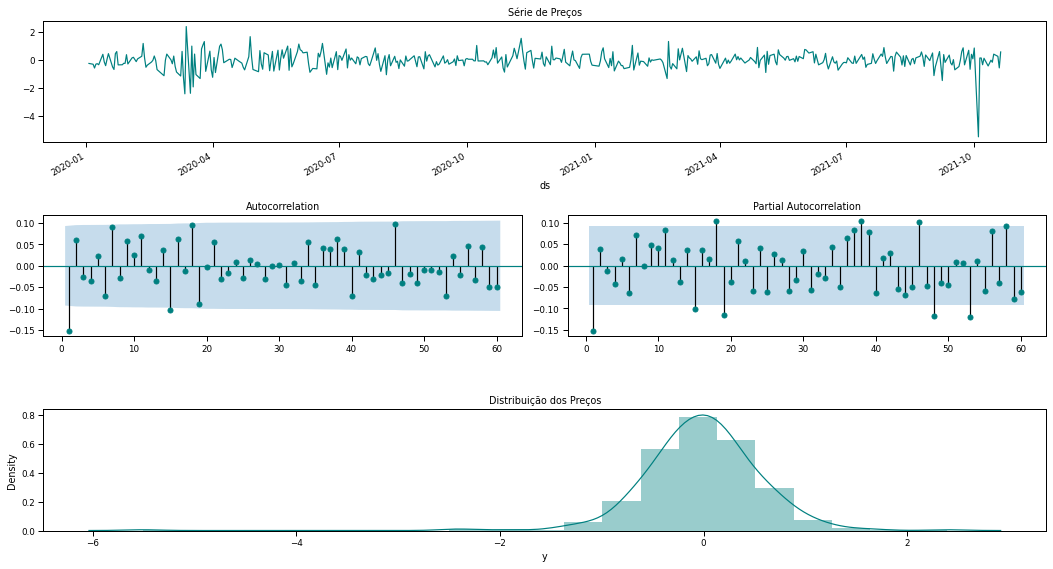

In [196]:
checar_estacionariedade(treino['y'].diff().dropna(), lags_plots=60)

O teste de Dickey Fuller retornou o valor P de zero, isso significa que a série tornou-se estacionária, para complementar, nota-se no gráfico que a tendência desapareceu e os preços estão relativamente estáveis.

No gráfico de auto correlação os valores vão decrescendo gradualmente, diferente do gráfico sem diferenciação.

A auto correlação parcial cai mais abruptamente, demonstrando que os valores que realmente impactam sobre os valores atuais são principalmente os 3 primeiros lags, aparentemente não há correlação sazonal significativa para ser considerada nas previsões.

Dessa maneira, podemos considerar os 3 primeiros lags para um modelo ARIMA com uma diferenciação, assim sendo usaremos a seguinte terminologia para o modelo: ARIMA(3,1,0)

#Criando o Modelo

Inicialmente o modelo será criado com base nos dados de treino, assim, os coeficientes para os 3 lags auto correlacionados serão gerados e servirão para testar a extrapolação de 5 dias consecutivos na base de testes.

Existem diversas maneiras de se fazer extrapolações para o futuro, as principais são:

Criar um modelo para cada dia a ser previsto e agregar tudo posteriormente,
Recursivo, prevendo o primeiro dia e usar essa previsão como base para prever o próximo dia.
Usaremos o último modelo neste exemplo, neste caso iremos prever os próximos 5 dias, comparar com dados reais, adicionar estes últimos novamente na base para fazer uma nova extrapolação, posteriormente iremos calcular o erro do modelo e analisar fatos relevantes da previsão.

In [197]:
# Treinando o modelo
modelo = ARIMA(treino, order=(3,1,0)).fit()
pred_treino = modelo.predict()

Vamos agora comparar os dados reais com os previstos, como a previsão foi feita sobre o modelo com diferenciação (como pode ser visto abaixo) o primeiro valor real será adicionado e somado cumulativamente para ter de volta a base de preço em R$/m3.

In [198]:
# Base de previsão com diferenciação
pred_treino[:5]

ds
2020-01-03   -0.019142
2020-01-06    0.016379
2020-01-07    0.014516
2020-01-08    0.055104
2020-01-09    0.005067
dtype: float64

In [199]:
# Voltando para a base de preços em R$/m3
pred_treino[0] += treino.iloc[0,0]
pred_treino = np.cumsum(pred_treino)
pred_treino.head()

ds
2020-01-03    30.494047
2020-01-06    30.510426
2020-01-07    30.524942
2020-01-08    30.580046
2020-01-09    30.585112
dtype: float64

In [200]:
treino['Pred Y'] = pred_treino
treino.dropna(inplace=True)
treino.head()

,y,Pred Y
ds,,
2020-01-03,30.260477,30.494047
2020-01-06,29.951593,30.510426
2020-01-07,29.371286,30.524942
2020-01-08,29.071764,30.580046
2020-01-09,28.800327,30.585112


Agora os valores previstos serão adicionados na variável de treino para plotarmos o gráfico com as duas séries:

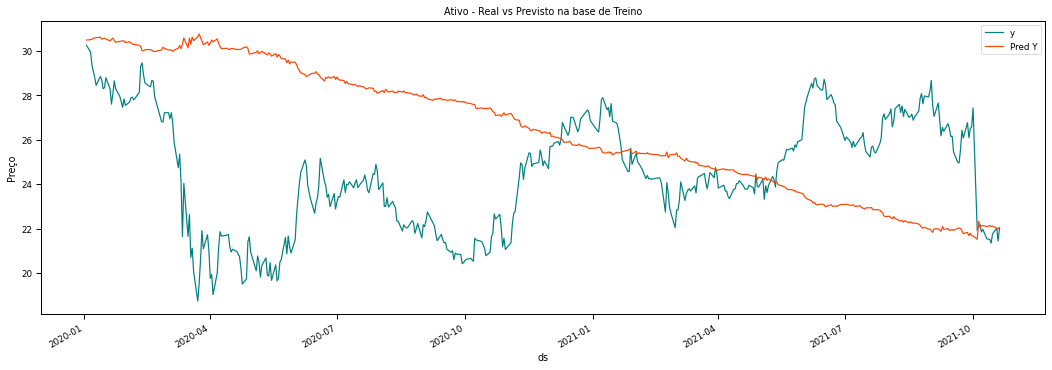

In [201]:
# Plotando o gráfico
treino.plot(figsize=(18,6), 
            title='Ativo - Real vs Previsto na base de Treino',
           color=['Teal','orangered'])
plt.ylabel('Preço')
plt.show()

Na base de treino o modelo consegue capturar os principais momentos do mercado. Somente quando há maiores variações que a previsão não consegue capturar o movimento, agora vamos analisar o erro do modelo:

In [202]:
#Medindo o erro do treino pela métrica Root Mean Squared Error
from sklearn.metrics import mean_squared_error
erro = sqrt(mean_squared_error(treino['y'], treino['Pred Y']))
print(f'O RMSE foi de {round(erro,4)}/sc')

O RMSE foi de 4.849/sc


#Obtendo os Coeficientes

Após treinar o modelo, podemos obter os coeficientes de multiplicação dos lags junto com o valor da constante, esses valores servirão como base para extrapolarmos as previsões para os próximos 5 dias.

In [203]:
# Pegando os coeficientes de múltiplicação dos lags para usar na base de testes:
const, l1, l2, l3 = modelo.params

print(f'Valor da constante {round(const,4)}')
print(f'Coeficientes do Lag 1: {round(l1,4)}, Lag 2: {round(l2,4)} e Lag 3: {round(l3,4)}')

Valor da constante -0.0191
Coeficientes do Lag 1: -0.1459, Lag 2: 0.0358 e Lag 3: -0.0116


O próximo passo é criar uma função para fazer as previsões, usarei todas as bases com diferenciação, criarei a previsão para 5 períodos adiante e atualizarei os dados reais com mais 5 dias e assim sucessivamente até finalizarem os dados de teste.

In [204]:
def prever_n_per(treino, teste, passos):
    
    # Adicionando a série com diferenciação para projetar previsões
    diff_treino = treino.diff().dropna().values
    hist = [x for x in diff_treino]

    diff_teste = teste.diff().dropna().values
    diff_teste = [x for x in diff_teste]

    # Adicionando primeira diferenciação no teste que ficou entre o treino e teste
    prim_diff = teste[0] - treino[-1]
    diff_teste.insert(0, prim_diff)
    
    prev = []

    for i in range(0,len(teste),passos):
        for j in range(passos):
    
            yhat = const + (l1 * hist[-1]) + (l2 * hist[-2]) + (l3 * hist[-3])
            prev.append(yhat)
            # usando a previsão atual como base para novas previsões
            hist.append(yhat)
        obs = diff_teste[i:i+passos]
        hist = list(np.append(hist,obs))
    return prev

In [205]:
# Testando a função
steps = 5
prev = prever_n_per(treino['y'], teste['y'], passos=steps)
print('Previsões antes de reverter os preços: ')
print(prev[:5])

Previsões antes de reverter os preços: 
[-0.12595943499375412, 0.0263235754968686, -0.03412889313640041, -0.011756188464189764, -0.01895326890912221]


Do mesmo jeito que criamos a função para prever os preços com 5 dias de extrapolação, iremos criar a função abaixo para transformar os preços previstos para a base comparável com os preços reais da base de teste.

In [206]:
def inverter_diff(treino, teste, previsão, passos):
    '''
    Usando o último dia da base de treino, após isso, usa o último valor previsto como base sucessivamente.
    
    A cada passo, volta a usar o primeiro valor da base de teste que se tornou real.
    '''
    treino = [x for x in treino]
    teste = [x for x in teste]
    prev_inv = []
    
    for i in range(0,len(teste), passos): 
        inverter = previsão[i] + treino[-1]
        prev_inv.append(inverter)
        
        for j in range(passos-1):
            inverter += previsão[i+j+1]
            prev_inv.append(inverter)
        treino = np.append(treino, teste[i:i+passos])
    return prev_inv

In [207]:
# Adicionando a previsão na base de testes para comparar posteriormente
teste['Previsão 5D'] = inverter_diff(treino['y'],
                                    teste['y'],
                                    prev, passos=steps)

#Plotando o Comparativo

Para finalizar, a função abaixo irá separar cada previsão pelos períodos de 5 dias e comparar com a base de testes:

In [208]:
def plotar_comparativo(orig, prev, passos, titulo='', figsize=(18,8)):
    plt.figure(figsize=figsize)
    
    orig = np.array(orig)
    prev = np.array(prev)
    plt.plot(orig, label='Real', color='teal')
    
    for i in range(0,len(orig), passos):
        eixo_x = [x for x in range(i,i+passos)]
        plt.plot(eixo_x, prev[i:i+passos], color='orangered')
    
    plt.title(titulo)
    plt.ylabel('Preços')
    plt.show()

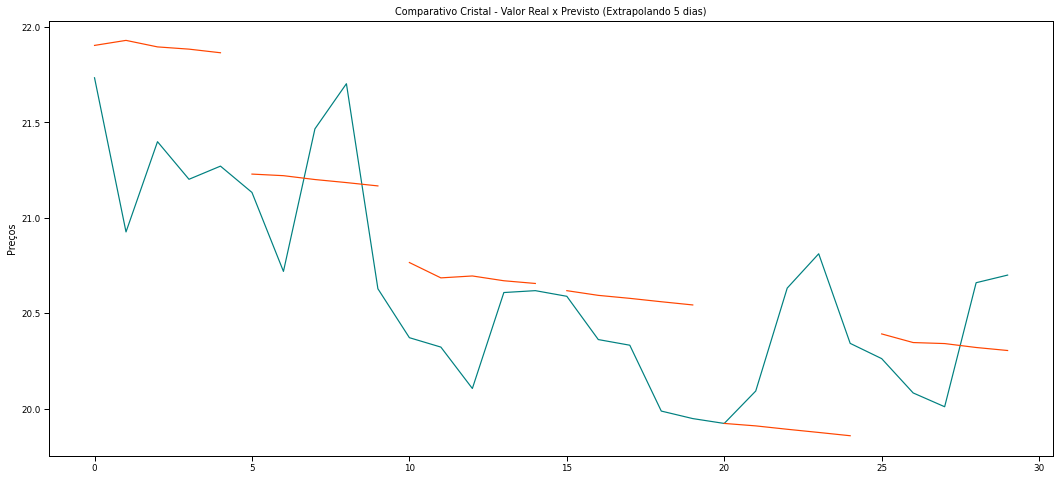

In [209]:
plotar_comparativo(teste['y'], teste['Previsão 5D'], passos=steps, 
                   titulo='Comparativo Cristal - Valor Real x Previsto (Extrapolando 5 dias)')

In [210]:
erro_teste = sqrt(mean_squared_error(teste['y'], teste['Previsão 5D']))
print(f'O RMSE da base de testes foi de {round(erro_teste,4)}/sc')

O RMSE da base de testes foi de 0.4687/sc


Avaliando o gráfico acima, nota-se que a principal característica desse tipo de previsão é que ele segue a tendência mais recente que está sendo negociada, porém ainda há espaço para melhoras, o modelo não é capaz de prever possíveis mudanças de tendências.

No próximo vai ser analisar o erro (previsto - real), pois neste tipo de análise pode-se obter informações para melhorar o modelo.

#Analisando o Erro

Para analisar o erro criarei uma função semelhante às anteriores, irão ser analisados os valores médios de cada um dos 5 passos, normalmente a tendência é que o erro, neste caso o RMSE, aumente de acordo com os períodos que vão se expandindo devido às incertezas, veremos abaixo:

In [211]:
def erro_n_passos(orig, prev, passos, plot=True):
    # Calculando o RMSE de cada linha
    erro = ((np.array(orig) - np.array(prev))**2)**(1/2)
    
    # Mudando o formato para ficar: (erros/exemplos, passos)
    erro = erro.reshape(int(len(erro)/passos), passos)
    
    # Fazendo a média do erro para cada passo
    media = erro.mean(axis=0)
    
    # Plotando o gráfico de erro
    if plot:
        indice = np.arange(0,passos)
        plt.figure(figsize=(12,4))
        plt.plot(media, 'o-', color='teal', markersize=8)
        plt.title('Erro Médio para Cada Passo', fontsize=15)
        plt.xlabel('Passos', fontsize=15)
        plt.ylabel('Erro', fontsize=15)
        for x,y in zip(indice, media):
            label = "{:.4f}".format(y)
            plt.annotate(label, (x, y), xytext=(x-0.1, y+.075), fontsize=12)
        plt.xticks(np.arange(passos), [x for x in range(1,passos+1)])
        plt.yticks([x for x in np.linspace(min(media)-0.2, max(media)+0.2, 10)])
        plt.grid(axis='y')
        plt.show()
    print(f'O RMSE para cada passo ficou assim: \n{media}')

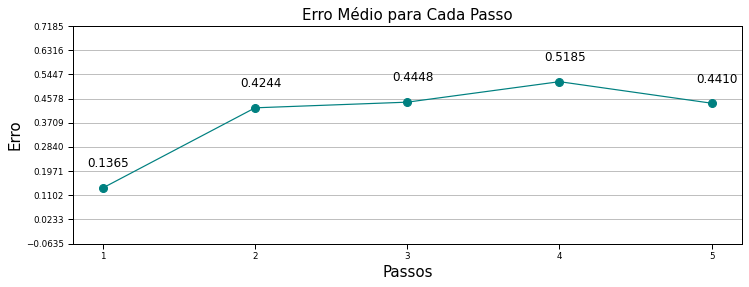

O RMSE para cada passo ficou assim: 
[0.13645188 0.42444685 0.44478633 0.51849827 0.44097355]


In [212]:
erro_passo = erro_n_passos(teste['y'], teste['Previsão 5D'], steps)
erro_passo

Como previsto, a cada passo, a tendência é que o erro aumente, isso é devido ao aumento das incertezas quanto ao futuro e também que as previsões a partir do segundo passo são feitas sobre valores previstos e não reais.

Abaixo algumas ideias podem ajudar a melhorar a acurácia do modelo:

Pode-se criar um ensemble de vários modelos (LSTM, Garch, MLP, TBATS, etc) e fazer uma média dos preços,
Alguns modelos podem ter previsões melhores para algum período específico, pode-se usar a cada período o modelo que tiver o menor erro, podendo assim, ter um modelo final com bases de modelos diferentes e com erros menores,
Analisar métricas de erro diferentes tipo MAE, Bias, etc para verificar características Específicas de cada tipo de métrica,
Testar possíveis lags sazonais para prever movimentos recorrentes,
Adicionar dados externos correlacionados,
Normalizar os dados,
Fazer a transformação com logaritmos ou usando a transformação Box-Cox.
Modelos simples ou até com técnicas de Inteligência Artificial para criar previsões com vários períodos adiante são sem dúvidas uma ferramenta de extrema importância.

Diante de um mercado cada vez mais competitivo, criar um modelo com acurácia testada pode ser um diferencial para a empresa, pois ela poderá captar possíveis movimentos de mercado que podem ser essenciais na tomada de decisão do administrador.

Modelos semelhantes a este podem ser usados como ferramentas auxiliares para se criar fluxos de caixa, administrar produção e estoques, como também identificar oportunidades de mercado.

Espero que tenha gostado, qualquer dúvida ou informação, estou à disposição para responder eventuais questionamentos, segue também o link do meu LinkedIn para contato.

#Adicional:

Abaixo criei uma animação, mostrando a dinâmica das previsões com as atualizações dos preços reais posteriormente:

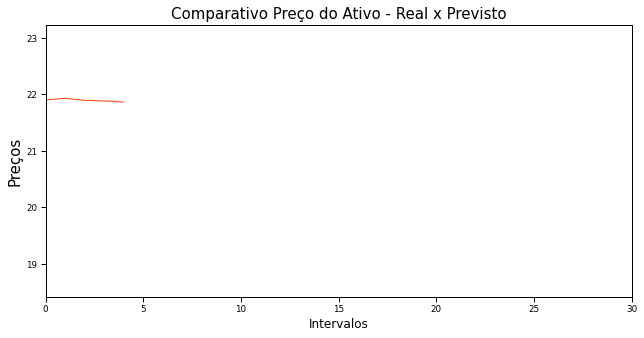

In [213]:
#%matplotlib notebook

passos = 5
eixo_x_prev = []
eixo_x_real = [x for x in range(len(teste))]
prev = []
pred = np.array([x for x in teste['Previsão 5D']])
base = [x for x in teste['y']]

for i in range(0,len(teste), passos):
    eixo_x_prev.append([x for x in range(i,i+passos)])
    prev.append([x for x in pred[i:i+passos]])

# Criando a base dos gráficos
fig = plt.figure(figsize=(10.5,5))
plt.axis([0, len(base), min(base)-2.5,max(base)+2.5])

def animate(i):
    
    plt.plot(eixo_x_prev[i], prev[i], c='orangered', lw=1)
    plt.plot(eixo_x_real[:i*passos], base[:i*passos], c='teal', lw=0.50)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Preços', fontsize=15)
plt.title('Comparativo Preço do Ativo - Real x Previsto', fontsize=15)
plt.axis([0, len(base), min(base)-1.5 ,max(base)+1.5])
    

ani = FuncAnimation(fig, animate, frames=50, interval=250)
#ani.save('/content/comparativo.htm')
plt.show()
